In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", 200)

resume_df = pd.read_csv("clean_resume_data.csv")
jobs_df = pd.read_csv("jobs_dataset_with_features.csv")

print("Resume Dataset Shape:", resume_df.shape)
print("Jobs Dataset Shape:", jobs_df.shape)

print("\nResume Dataset Columns:")
print(resume_df.columns)

print("\nJobs Dataset Columns:")
print(jobs_df.columns)


Resume Dataset Shape: (2484, 3)
Jobs Dataset Shape: (1615940, 2)

Resume Dataset Columns:
Index(['ID', 'Category', 'Feature'], dtype='object')

Jobs Dataset Columns:
Index(['Role', 'Features'], dtype='object')


In [2]:

print("Resume missing values:\n", resume_df.isnull().sum())
print("\nJobs missing values:\n", jobs_df.isnull().sum())


print("\n--- Sample Resume Rows ---")
display(resume_df.sample(3))


print("\n--- Sample Job Rows ---")
display(jobs_df.sample(3))


Resume missing values:
 ID          0
Category    0
Feature     1
dtype: int64

Jobs missing values:
 Role        0
Features    0
dtype: int64

--- Sample Resume Rows ---


,ID,Category,Feature
569,14726000,BUSINESS-DEVELOPMENT,business development consultant mar summary highly motivated individual seven years financial industry experience specifically areas risk management compliance skills strengths include limited exc...
1275,33542483,DIGITAL-MEDIA,digital content editor summary devoted writer editor inspired tell stories solid experience print digital magazine corporate communications project management traversed fields journalism help grow...
489,72652441,ADVOCATE,customer care advocate experience customer care advocate current company name city state respond phone calls correspondence including limited appeals corrected claims timely filing claims projects...



--- Sample Job Rows ---


,Role,Features
934921,Child Custody Lawyer,"3 to 14 Years Family Lawyer M.Com Child custody law Family law Legal advocacy Negotiation Court representation Legal research Client counseling Case preparation Specialize in child custody cases, ..."
667883,IT Project Manager,"5 to 11 Years Project Manager MBA Project management Team leadership Risk management Budgeting Communication skills Plan and oversee IT projects, manage project teams, and ensure successful projec..."
364409,Web Designer,"4 to 8 Years Front-End Developer B.Tech Web design concepts Graphic design software (e.g., Adobe Creative Suite) HTML and CSS Responsive design User interface (UI) principles Visual communication ..."


In [3]:
resume_df = resume_df.dropna(subset=["Feature"]).reset_index(drop=True)
print(resume_df.shape)

jobs_sample_df = jobs_df.sample(n=5000, random_state=42).reset_index(drop=True)
print(jobs_sample_df.shape)

resume_texts = resume_df["Feature"]
job_texts = jobs_sample_df["Features"]

len(resume_texts), len(job_texts)

(2483, 3)
(5000, 2)


(2483, 5000)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 2),
    stop_words="english"
)

resume_tfidf = vectorizer.fit_transform(resume_texts)
job_tfidf = vectorizer.transform(job_texts)

resume_tfidf.shape, job_tfidf.shape


((2483, 15000), (5000, 15000))

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(resume_tfidf, job_tfidf)

similarity_matrix.shape


(2483, 5000)

In [9]:
def get_top_jobs_for_resume(resume_index, top_n=5):
    scores = similarity_matrix[resume_index]
    top_indices = scores.argsort()[::-1][:top_n]
    return jobs_sample_df.loc[top_indices, ["Role", "Features"]].assign(
        Match_Score=(scores[top_indices] * 100).round(2)
    )

get_top_jobs_for_resume(0, top_n=5)


,Role,Features,Match_Score
473,Marketing Communications Director,"2 to 13 Years Marketing Director BCA Marketing communication Public relations Content strategy Crisis management Media relations Lead marketing communications efforts, including public relations a...",18.61
257,Marketing Communications Director,"4 to 13 Years Marketing Director B.Com Marketing communication Public relations Content strategy Crisis management Media relations Lead marketing communications efforts, including public relations...",18.48
3293,Marketing Communications Director,"1 to 9 Years Marketing Director B.Com Marketing communication Public relations Content strategy Crisis management Media relations Lead marketing communications efforts, including public relations ...",18.48
3719,Marketing Communications Director,"1 to 14 Years Marketing Director MBA Marketing communication Public relations Content strategy Crisis management Media relations Lead marketing communications efforts, including public relations a...",18.46
1765,Marketing Communications Director,"2 to 9 Years Marketing Director M.Tech Marketing communication Public relations Content strategy Crisis management Media relations Lead marketing communications efforts, including public relations...",18.46


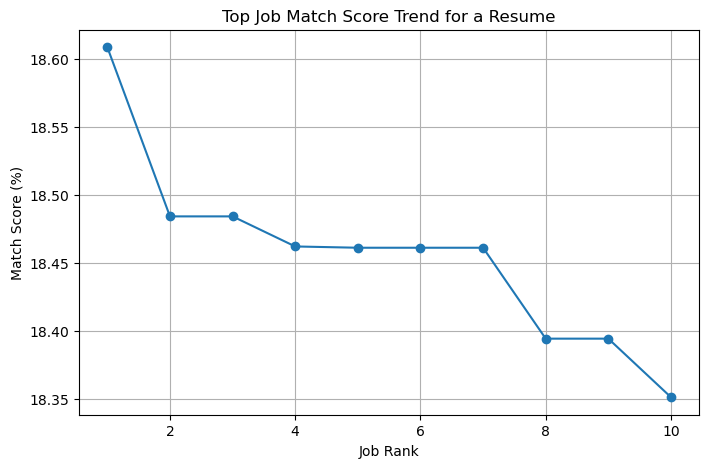

In [10]:
import matplotlib.pyplot as plt

resume_index = 0
scores = similarity_matrix[resume_index]

top_n = 10
top_scores = np.sort(scores)[::-1][:top_n]

plt.figure(figsize=(8, 5))
plt.plot(range(1, top_n + 1), top_scores * 100, marker='o')
plt.xlabel("Job Rank")
plt.ylabel("Match Score (%)")
plt.title("Top Job Match Score Trend for a Resume")
plt.grid(True)
plt.show()

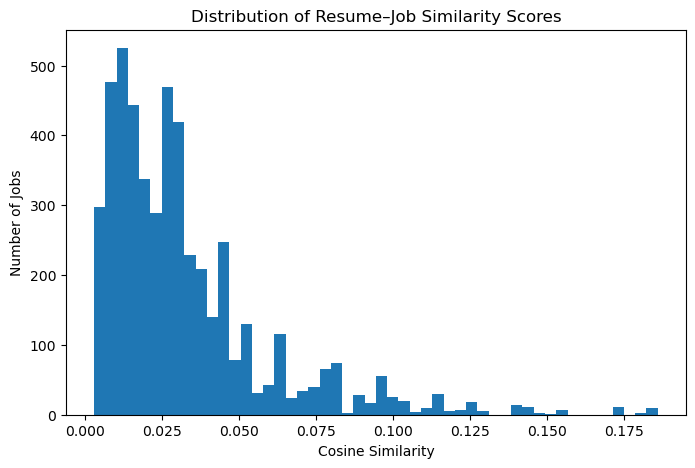

In [11]:
plt.figure(figsize=(8, 5))
plt.hist(scores, bins=50)
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Jobs")
plt.title("Distribution of Resume–Job Similarity Scores")
plt.show()


In [13]:
import pickle

model_bundle = {
    "vectorizer": vectorizer,
    "job_tfidf": job_tfidf,
    "jobs_df": jobs_sample_df
}

with open("resume_job_matcher.pkl", "wb") as f:
    pickle.dump(model_bundle, f)
